# Selection of 50 NLQ queries
 • Model Used : VSLNet (Non-Shared version)

### Mapping Predictions to their Video_Uid
The following blocks ares used to map each predictions to the relative video uid. Somehow, the output of the VSLNet model do not include this information.

In [13]:
import json
import os

# Define paths to data directory and files
annotations_dir = "data/ego4d_data"
predictions_dir = "data/prediction_VSLNet_Non_Shared"

annotations_file = os.path.join(annotations_dir, "v1", "annotations/nlq_val.json")
predictions_file = os.path.join(predictions_dir, "predictions.json")
updated_predictions_file = os.path.join(predictions_dir, "predictions_with_video_id.json")


**N.B.**
**All'interno delle annotations ground truth vi sono degli errori in virgola mobile, valori prossimi a 0 ma negativi, FIXED**

In [24]:
# Step 1: Create a mapping from clip_uid to video_id
def create_clip_to_video_mapping(annotations_path):
    with open(annotations_path, 'r') as f:
        annotations = json.load(f)
    
    clip_to_video = {}
    for video in annotations["videos"]:
        video_id = video["video_uid"]  # Extract video_id
        for clip in video["clips"]:
            clip_id = clip["clip_uid"]  # Extract clip_id
            annotations = clip["annotations"]
            clip_to_video[clip_id] = { "video_id": video_id, "annotations": annotations}  # Map clip_id to video_id
    
    return clip_to_video
    

# Step 2: Update predictions with video_id and ground truth
def add_video_id_to_predictions(predictions_path, clip_to_video_mapping, output_path):
    with open(predictions_path, 'r') as f:
        predictions = json.load(f)
    
    for result in predictions["results"]:
        clip_id = result["clip_uid"]
        annotation_uid = result["annotation_uid"]
        query_idx = result["query_idx"]
        infos = clip_to_video_mapping.get(clip_id, "unknown")  
        if infos == "unknown":
            print(f"Clip {clip_id} not found in annotations")
        else:
            result["video_id"] = infos["video_id"]                          # Add video_id
            for annotation in infos["annotations"]:
                if annotation["annotation_uid"] == annotation_uid:
                    query = annotation["language_queries"]
                    break
            if query is None:
                print(f"Annotation {annotation_uid} not found in annotations")
                result["ground_truth"] = None
            else:
                # check if is major than 0 
                video_start_time = query[query_idx]["video_start_sec"] if query[query_idx]["video_start_sec"] > 0 else 0
                video_end_time = query[query_idx]["video_end_sec"]
                result["ground_truth"] = [video_start_time, video_end_time]     # Add ground truth
    
    # Save updated predictions
    with open(output_path, 'w') as f:
        json.dump(predictions, f, indent=4)

clip_to_video = create_clip_to_video_mapping(annotations_file)
# Update predictions
add_video_id_to_predictions(predictions_file, clip_to_video, updated_predictions_file)    
print(f"Predictions updated and saved to {updated_predictions_file}")


Predictions updated and saved to data/prediction_VSLNet_Non_Shared/predictions_with_video_id.json


### Selection of 50 best NLQ queries

In [25]:
### CODE SECTIONS TAKEN BY THE OFFICIAL NLQ EVALUATION SCRIPT ###
### SEE   "VSLNet_Non_Shared/UTILS/eval_nlq.py"   FOR MORE DETAILS###
import numpy as np


def compute_IoU(pred, gt):
    """Compute the IoU given predicted and ground truth windows."""
    assert isinstance(pred, list) and isinstance(gt, list)
    pred_is_list = isinstance(pred[0], list)
    gt_is_list = isinstance(gt[0], list)
    if not pred_is_list:
        pred = [pred]
    if not gt_is_list:
        gt = [gt]
    pred, gt = np.array(pred), np.array(gt)
    inter_left = np.maximum(pred[:, 0, None], gt[None, :, 0])
    inter_right = np.minimum(pred[:, 1, None], gt[None, :, 1])
    inter = np.maximum(0.0, inter_right - inter_left)
    union_left = np.minimum(pred[:, 0, None], gt[None, :, 0])
    union_right = np.maximum(pred[:, 1, None], gt[None, :, 1])
    union = np.maximum(0.0, union_right - union_left)
    overlap = 1.0 * inter / union
    if not gt_is_list:
        overlap = overlap[:, 0]
    if not pred_is_list:
        overlap = overlap[0]
    return overlap


def evaluate_nlq_performance(
    predictions, ground_truth, thresholds, topK, per_instance=False
):
    """Evalutes the performances."""
    gt_dict = {}
    num_gt_queries = 0

    for video_datum in ground_truth["videos"]:
        for clip_datum in video_datum["clips"]:
            clip_uid = clip_datum["clip_uid"]
            for ann_datum in clip_datum["annotations"]:
                key = (clip_uid, ann_datum["annotation_uid"])
                gt_dict[key] = ann_datum
                num_gt_queries += len(ann_datum["language_queries"])

    results = [[[] for _ in topK] for _ in thresholds]
    average_IoU = []
    num_instances = 0
    
    for pred_datum in predictions:
        key = (pred_datum["clip_uid"], pred_datum["annotation_uid"])
        assert key in gt_dict, "Instance not present!"
        query_id = pred_datum["query_idx"]
        gt_datum = gt_dict[key]
        gt_query_datum = gt_datum["language_queries"][query_id]

        # Compute overlap and recalls.
        overlap = compute_IoU(
            pred_datum["predicted_times"],
            [[gt_query_datum["clip_start_sec"], gt_query_datum["clip_end_sec"]]],
        )
        average_IoU.append(np.mean(np.sort(overlap[0])[-3:]))
        for tt, threshold in enumerate(thresholds):
            for rr, KK in enumerate(topK):
                results[tt][rr].append((overlap > threshold)[:KK].any())
        num_instances += 1

    mean_results = np.array(results).mean(axis=-1)
    mIoU = np.mean(average_IoU)
    print(f"Evaluated: {num_instances} / {num_gt_queries} instances")
    if per_instance:
        per_instance_results = {
            "overlap": overlap,
            "average_IoU": average_IoU,
            "results": results,
        }
        return mean_results, mIoU, per_instance_results
    else:
        return mean_results, mIoU

In this section we extract the average IoU (calculated over different thresholds).

In [26]:
import json 

# Path al file delle predictions e ground truth
predictions_file = "data/prediction_VSLNet_Non_Shared/predictions_with_video_id.json"
gt_json_path = "data/ego4d_data/v1/annotations/nlq_val.json"

# Parametri di valutazione
thresholds = [0.3, 0.5, 0.01]
topK = [1, 3, 5]

# Caricamento dei dati
with open(predictions_file, 'r') as pred_file:
    predictions = json.load(pred_file)["results"]

with open(gt_json_path, 'r') as gt_file:
    ground_truth = json.load(gt_file)

# Valutazione
_, _, per_instance_results = evaluate_nlq_performance(
    predictions, ground_truth, thresholds, topK, per_instance=True
)

# create an array containing only the average IoU values
average_IoU = np.array(per_instance_results["average_IoU"])
print(f"Length of IoU array: {len(average_IoU)}")

Evaluated: 3874 / 3875 instances
Length of IoU array: 3874


In [30]:
def map_predictions_to_ground_truth(predictions, ground_truth):
    gt_dict = {}
    for video_datum in ground_truth["videos"]:
        for clip_datum in video_datum["clips"]:
            clip_uid = clip_datum["clip_uid"]
            for ann_datum in clip_datum["annotations"]:
                key = (clip_uid, ann_datum["annotation_uid"])
                gt_dict[key] = ann_datum
    return gt_dict

def combine_results_with_predictions(predictions, gt_dict, average_IoU):
    detailed_results = []
    for i, pred in enumerate(predictions):
        clip_uid = pred["clip_uid"]
        annotation_uid = pred["annotation_uid"]
        query_idx = pred["query_idx"]
        gt_entry = gt_dict[(clip_uid, annotation_uid)]
        query_text = gt_entry["language_queries"][query_idx]["query"]
        detailed_results.append({
            "video_id": pred["video_id"],
            "clip_uid": clip_uid,
            "annotation_uid": annotation_uid,
            "query": query_text,
            "iou": average_IoU[i],
            "ground_truth": pred["ground_truth"]
        })
    return detailed_results

gt_dict = map_predictions_to_ground_truth(predictions, ground_truth)
combined_results = combine_results_with_predictions(predictions, gt_dict, average_IoU)
print(f"Length of combined results: {len(combined_results)}")

top_queries = sorted(combined_results, key=lambda x: x["iou"], reverse=True)[:50]
for i, query in enumerate(top_queries):
    print(f"Query {i+1}: {query['query']} (IoU: {query['iou']}) -- (Video ID: {query['video_id']}, Clip UID: {query['clip_uid']} ,Ground Truth: {query['ground_truth']})")

# Save combined results to a file
output_file = "data/top_50_queries/top_queries.json"
with open(output_file, 'w') as f:
    json.dump(top_queries, f, indent=4)

print(f"Top queries salvate in formato JSON nel file: {output_file}")


Length of combined results: 3874
Query 1: Where did I saw socket ? (IoU: 0.9869048775762254) -- (Video ID: 8698a0ea-f434-49f9-a8e4-45220e5d4b2c, Clip UID: 2237fc47-e8c9-4751-9b02-6189913b4b4d ,Ground Truth: [719.9873697458333, 1193.1420364125])
Query 2: What vegetables did I chop?  (IoU: 0.9868421052631579) -- (Video ID: f082242c-309f-48a1-97fa-5c1d6bd255fb, Clip UID: 5d531ac1-010a-4e67-ba1a-96e485b14968 ,Ground Truth: [180.0210286, 218.0210286])
Query 3: In what location did I see a carton? (IoU: 0.9777777777777777) -- (Video ID: 0971527a-6cd3-4c82-9d94-09b3565f4505, Clip UID: 755ac5c3-b6cd-42da-ac72-c413d0be986a ,Ground Truth: [0, 10.999999599999999])
Query 4: What did I put in the pot (IoU: 0.9740671762206361) -- (Video ID: 4ce119de-0f42-4bd1-b387-9e19643fdddc, Clip UID: e1c79556-e8af-4e26-bc4c-633100277239 ,Ground Truth: [446.6319386, 461.29985860000005])
Query 5: how many green peppers did i put minced meat in? (IoU: 0.9696969696969697) -- (Video ID: 25e093a8-86d5-47e9-b09f-5a8afe

**Further analysis on combined results**

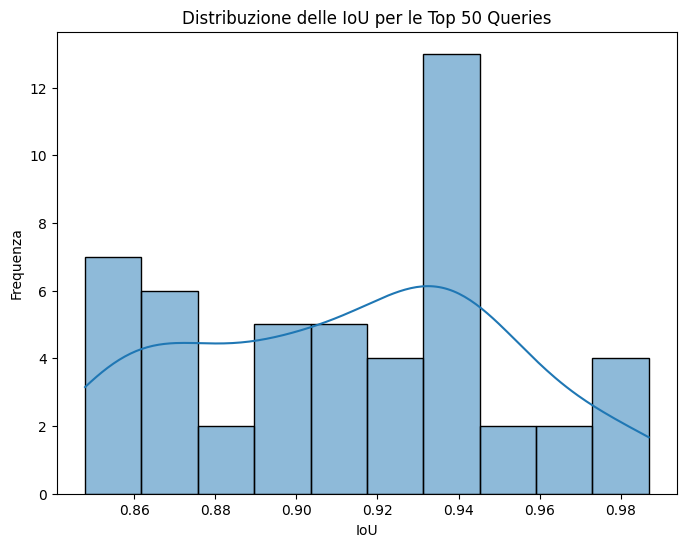

In [28]:
# Distribution of IoU values
import matplotlib.pyplot as plt
import seaborn as sns

iou_values = [query["iou"] for query in top_queries]

plt.figure(figsize=(8, 6))
sns.histplot(iou_values, bins=10, kde=True)
plt.title("Distribuzione delle IoU per le Top 50 Queries")
plt.xlabel("IoU")
plt.ylabel("Frequenza")
plt.show()

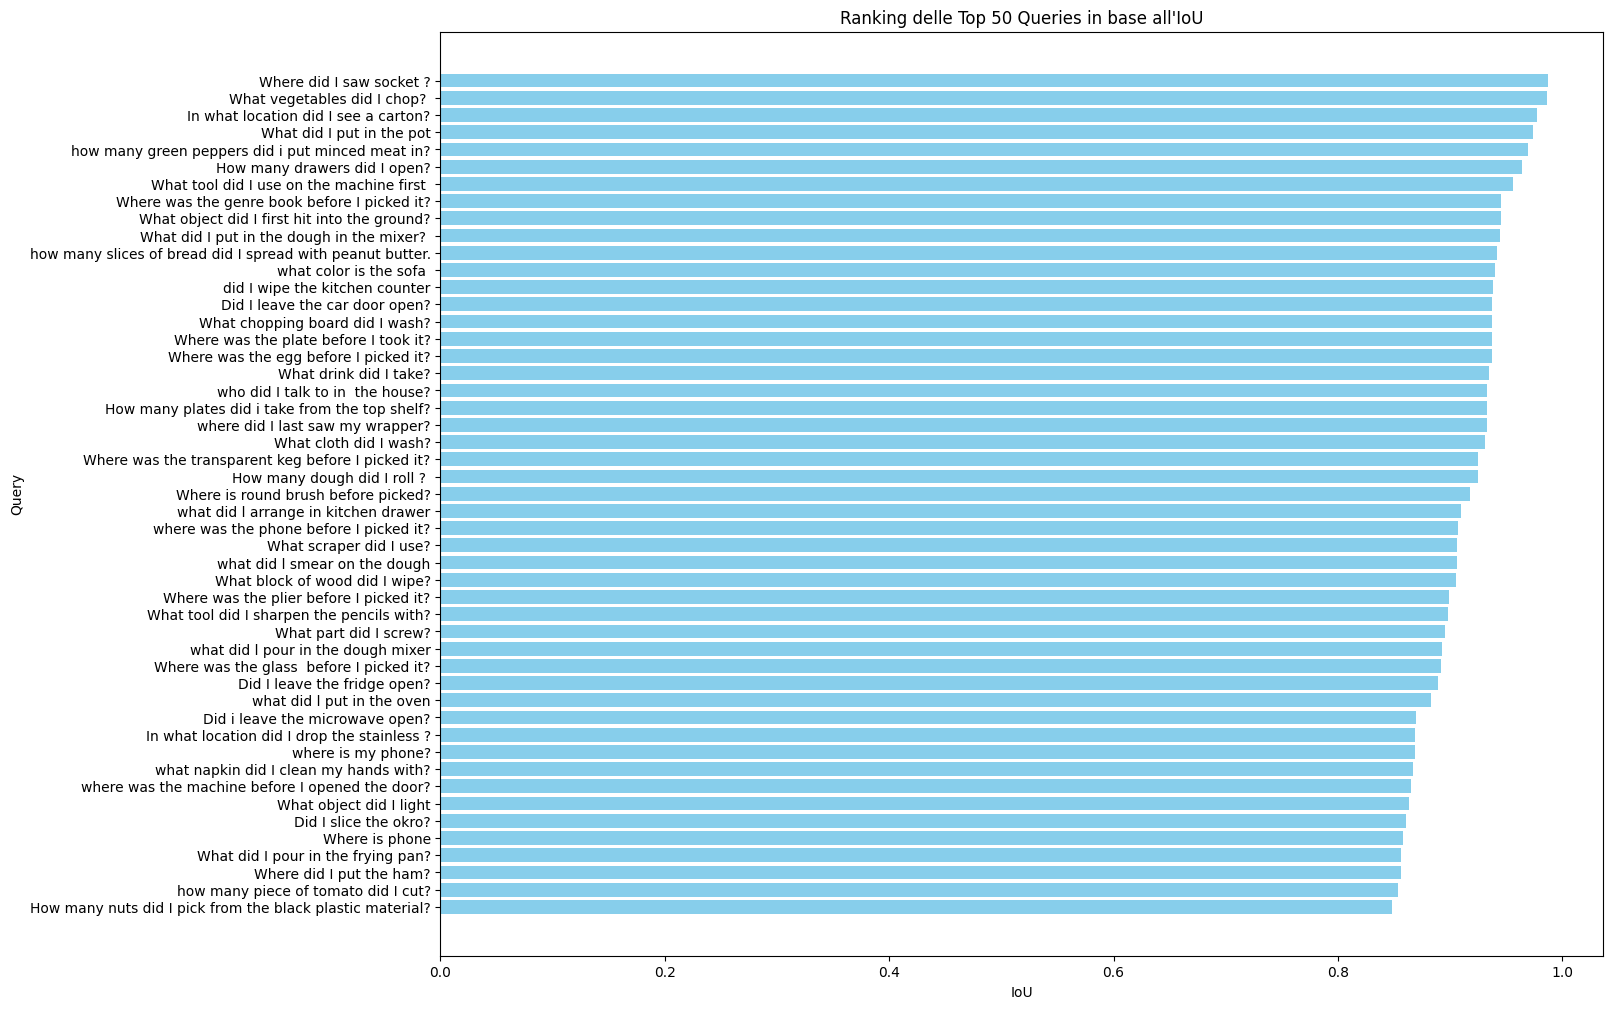

In [29]:
queries = [query["query"] for query in top_queries]
iou_values_sorted = sorted(iou_values, reverse=True)

plt.figure(figsize=(15, 12))
plt.barh(queries, iou_values_sorted, color='skyblue')
plt.title("Ranking delle Top 50 Queries in base all'IoU")
plt.xlabel("IoU")
plt.ylabel("Query")
plt.gca().invert_yaxis()
plt.show()